In [10]:
import os
import pickle

import networkx as nx
from tqdm import tqdm

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.io_utils as io_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.common.utils.misc_utils as misc_utils
from matching.glema.common.dataset import BaseDataset

In [11]:
args = arg_utils.parse_args( use_default=True )

args.dataset = "CPG_augm"
args.directed = False
args.anchored = False
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )

args = arg_utils.load_args( args, model_name )
args.iso = True
args.test_data = True

In [12]:
dataset_name = model_utils.get_dataset_name( args )
data_path = io_utils.get_abs_file_path( os.path.join( args.data_processed_dir, dataset_name ) )
data_path

'/Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/data/data_processed/CPG_augm'

In [13]:
key_file = os.path.join( data_path, args.test_keys if args.test_data else args.train_keys )
with open( key_file, "rb" ) as fp:
    keys = pickle.load( fp )
print( f"Number of test data: {len( keys )}" )
iso_key_idxs = [ i for i, k in enumerate( keys ) if "iso" in k ]
non_iso_key_idxs = [ i for i, k in enumerate( keys ) if "non" in k ]
print( f"Test data split: iso [{len( iso_key_idxs )}] / noniso [{len( non_iso_key_idxs )}]" )

Number of test data: 11648
Test data split: iso [5903] / noniso [5745]


In [14]:
complexity_keys = model_utils.load_complexity_keys( args, train=not args.test_data )
dataset = BaseDataset( keys, args, k_start=4, k_keys=complexity_keys )
#dataset.remove_complexity_limit()

In [15]:
matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}


def get_sample( dataset, sample_idx, relabel=True ):
    sample_data = dataset.get_data( sample_idx )
    query, source, mapping = sample_data
    mapping = { qnid: snid for qnid, snid in mapping }
    if relabel:
        query = graph_utils.relabel_nodes( query, mapping )
    return source, query, mapping


def get_colors( G ):
    return [ "purple" if d[ "anchor" ] == 1 else "grey" for n, d in G.nodes( data=True ) ]

{'H': array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0.

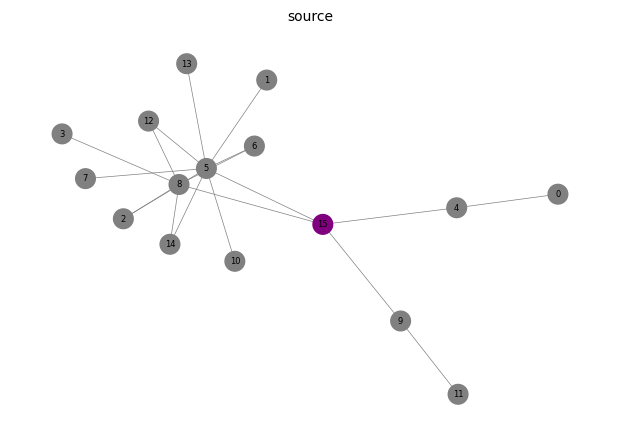

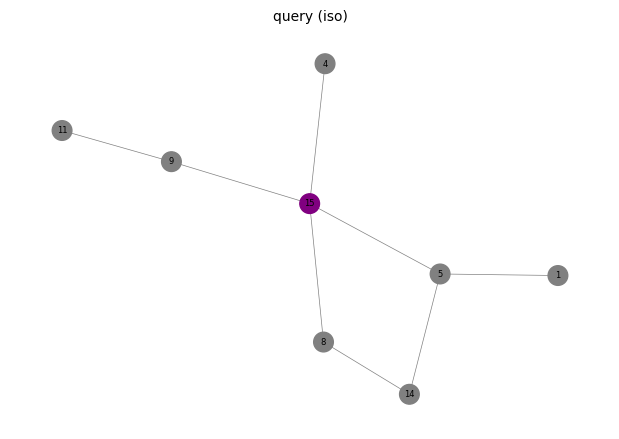

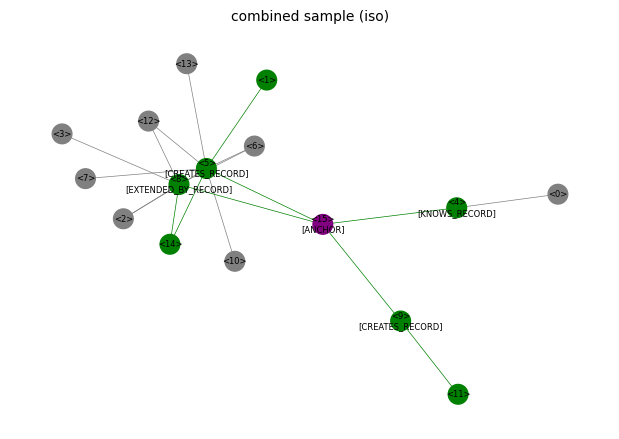

In [16]:
sample_idx = iso_key_idxs[ 0 ]
source, query, _ = get_sample( dataset, sample_idx )
print( dataset.__getitem__( sample_idx ) )
plot_utils.plot_graph( title="source", graph=source, nodeColors=get_colors( source ) )
plot_utils.plot_graph( title="query (iso)", graph=query, nodeColors=get_colors( query ) )

combined, n_colors, e_colors = graph_utils.combine_graph( source, query,
                                                          matching_colors=matching_colors )
plot_utils.plot_graph(
    title="combined sample (iso)", graph=combined,
    nodeColors=n_colors, edgeColors=e_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)

{'H': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0.

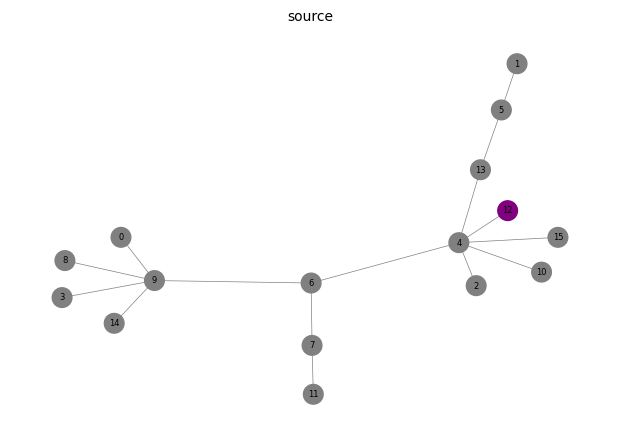

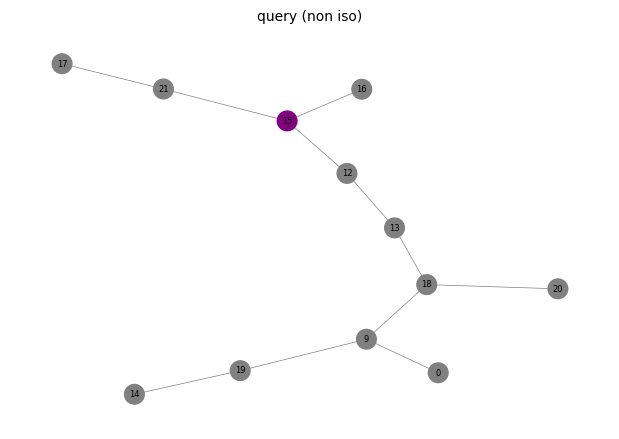

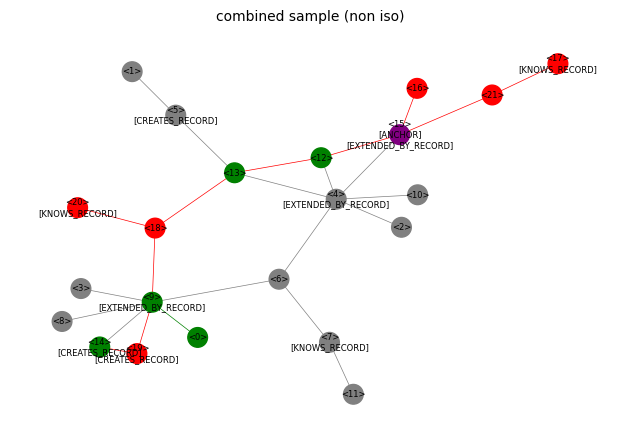

In [17]:
sample_idx = non_iso_key_idxs[ 4 ]
source, query, _ = get_sample( dataset, sample_idx )
print( dataset.__getitem__( sample_idx ) )
plot_utils.plot_graph( title="source", graph=source, nodeColors=get_colors( source ) )
plot_utils.plot_graph( title="query (non iso)", graph=query, nodeColors=get_colors( query ) )

combined, n_colors, e_colors = graph_utils.combine_graph( source, query,
                                                          matching_colors=matching_colors )
plot_utils.plot_graph(
    title="combined sample (non iso)", graph=combined,
    nodeColors=n_colors, edgeColors=e_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)

In [18]:
sources_with_anchor = 0
queries_with_anchor = 0
iso_samples_with_same_anchor = 0
non_iso_samples_with_same_anchor = 0

sources_max_5 = 0
sources_5_10 = 0
sources_10_15 = 0
sources_15_20 = 0
sources_20_30 = 0
sources_30_40 = 0
sources_min_40 = 0

queries_max_5 = 0
queries_5_10 = 0
queries_10_15 = 0
queries_15_20 = 0
queries_20_30 = 0
queries_30_40 = 0
queries_min_40 = 0

iso_samples_are_iso = 0
non_iso_samples_are_iso = 0
measure_iso = False

for sample_idx in tqdm( list( range( len( keys ) ) ) ):

    is_iso_sample = False
    if sample_idx in iso_key_idxs:
        is_iso_sample = True

    source, query, mapping = get_sample( dataset, sample_idx, relabel=True )

    source_anchor = graph_utils.get_anchor( source )
    if source_anchor >= 0:
        sources_with_anchor += 1

    query_anchor = graph_utils.get_anchor( query )
    if query_anchor >= 0:
        queries_with_anchor += 1

        if source_anchor == query_anchor:
            if is_iso_sample:
                iso_samples_with_same_anchor += 1
            else:
                non_iso_samples_with_same_anchor += 1
           
    source_size = source.number_of_nodes()  
    if source_size <= 5:
        sources_max_5 += 1
    if 5 < source_size <= 10:
        sources_5_10 += 1
    if 10 < source_size <= 15:
        sources_10_15 += 1
    if 15 < source_size <= 20:
        sources_15_20 += 1
    if 20 < source_size <= 30:
        sources_20_30 += 1
    if 30 < source_size <= 40:
        sources_30_40 += 1
    if 40 < source_size:
        sources_min_40 += 1
        
    query_size = query.number_of_nodes()  
    if query_size <= 5:
        queries_max_5 += 1
    if 5 < query_size <= 10:
        queries_5_10 += 1
    if 10 < query_size <= 15:
        queries_10_15 += 1
    if 15 < query_size <= 20:
        queries_15_20 += 1
    if 20 < query_size <= 30:
        queries_20_30 += 1
    if 30 < query_size <= 40:
        queries_30_40 += 1
    if 40 < query_size:
        queries_min_40 += 1
        
    if measure_iso:
        if graph_utils.is_iso_subgraph( source, query ):
            if is_iso_sample:
                iso_samples_are_iso += 1
            else:
                non_iso_samples_are_iso += 1
            

print( f"Sources with anchor: {sources_with_anchor}/{len( keys )}" )
print( f"Queries with anchor: {queries_with_anchor}/{len( keys )}" )
print( f"Iso samples with same anchor: {iso_samples_with_same_anchor}/{len( iso_key_idxs )}" )
print( f"Non iso samples with same anchor: {non_iso_samples_with_same_anchor}/{len( non_iso_key_idxs )}" )

print( f"Source samples with nodes size smaller 5: {sources_max_5}" )
print( f"Source samples with nodes size between 5-10: {sources_5_10}" )
print( f"Source samples with nodes size between 10-15: {sources_10_15}" )
print( f"Source samples with nodes size between 15-20: {sources_15_20}" )
print( f"Source samples with nodes size between 20-30: {sources_20_30}" )
print( f"Source samples with nodes size between 30-40: {sources_30_40}" )
print( f"Source samples with nodes size greater 40: {sources_min_40}" )

print( f"Queries samples with nodes size smaller 5: {queries_max_5}" )
print( f"Queries samples with nodes size between 5-10: {queries_5_10}" )
print( f"Queries samples with nodes size between 10-15: {queries_10_15}" )
print( f"Queries samples with nodes size between 15-20: {queries_15_20}" )
print( f"Queries samples with nodes size between 20-30: {queries_20_30}" )
print( f"Queries samples with nodes size between 30-40: {queries_30_40}" )
print( f"Queries samples with nodes size greater 40: {queries_min_40}" )

if measure_iso:
    print( f"Iso samples are iso: {iso_samples_are_iso}/{len( iso_key_idxs )}" )
    print( f"Non iso samples are iso: {non_iso_samples_are_iso}/{len( non_iso_key_idxs )}" )

100%|██████████| 11648/11648 [00:00<00:00, 12929.53it/s]

Sources with anchor: 11648/11648
Queries with anchor: 11648/11648
Iso samples with same anchor: 3436/5903
Non iso samples with same anchor: 3354/5745
Source samples with nodes size smaller 5: 1664
Source samples with nodes size between 5-10: 3072
Source samples with nodes size between 10-15: 2560
Source samples with nodes size between 15-20: 4352
Source samples with nodes size between 20-30: 0
Source samples with nodes size between 30-40: 0
Source samples with nodes size greater 40: 0
Queries samples with nodes size smaller 5: 4750
Queries samples with nodes size between 5-10: 3888
Queries samples with nodes size between 10-15: 2134
Queries samples with nodes size between 15-20: 876
Queries samples with nodes size between 20-30: 0
Queries samples with nodes size between 30-40: 0
Queries samples with nodes size greater 40: 0
